# Decomposing image into sum of basis images using matching pursuit (MP) algorithm

In [1]:
%matplotlib inline

In [2]:
import h5py
import dpmeans
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from skimage.util import img_as_float, img_as_uint
from scipy import ndimage
from scipy.stats import multivariate_normal

### Parameters

In [3]:
# Path to file containing Zimmer data
IN_FPATH = '/home/mn2822/Desktop/WormTracking/data/zimmer/mCherry_v00065-01581.hdf5'

# Relative threshold applied to image
THRESHOLD_REL = 0.15

# Minimum number of pixels for component to be considered
CELL_MIN_SIZE = 50

### Load Zimmer data

In [4]:
# Index of frame to use
t_frame = 500

with h5py.File(IN_FPATH, 'r') as f:
    dset = f.get('mCherry')
    frame = dset[t_frame, 0, :, :, :]
    frame = np.moveaxis(frame, [0, 1, 2], [2, 1, 0])

### Select section of frame for test image

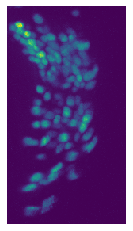

In [5]:
# Section of XY plane where head is found
head_x = (500, 650)
head_y = (250, 525)
head_z = (0, 33)

# Extract section
img = frame[head_x[0]:head_x[1], head_y[0]:head_y[1], head_z[0]:head_z[1]]
img = img_as_float(img)

# Compute image min and max
img_min = np.min(img)
img_max = np.max(img)

# Display max projection
plt.imshow(np.max(img, 2).T);
plt.axis('off');

### TODO:

1. Create weight function
2. Implement single step of MP procedure
3. Write loop

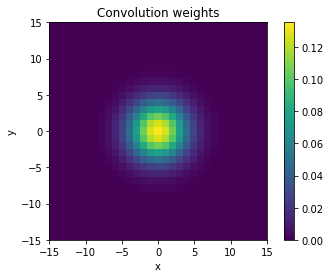

In [6]:
wx = 15
wy = 15
wz = 5
xg, yg, zg = np.mgrid[-wx:wx+1, -wy:wy+1, -wz:wz+1]
weight_grid = np.stack((xg, yg, zg), axis=-1)

mean = np.array([0, 0, 0]) 
cov = np.diag([8.0, 8.0, 1.5])
weights_nn = multivariate_normal.pdf(weight_grid, mean=mean, cov=cov)
weights = weights_nn / np.sqrt(np.sum(weights_nn ** 2))

plt.imshow(np.max(weights, 2).T, origin='lower', extent=[-15, 15, -15, 15])
plt.title('Convolution weights')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar();

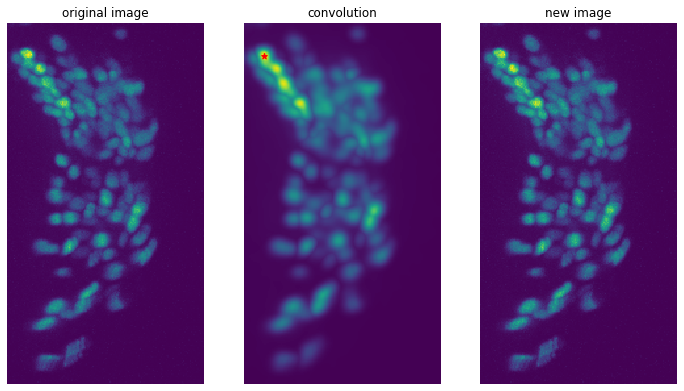

In [7]:
img_cp = np.copy(img)
conv = np.zeros(img.shape)

ndimage.filters.convolve(img, weights, output=conv)
max_pt = np.unravel_index(np.argmax(conv), conv.shape)
pix_val = img[max_pt]

x_min = max_pt[0] - wx
x_max = max_pt[0] + wx + 1
y_min = max_pt[1] - wy
y_max = max_pt[1] + wy + 1
z_min = max_pt[2] - wz
z_max = max_pt[2] + wz + 1
img_cp[x_min:x_max, y_min:y_max, z_min:z_max] = img_cp[x_min:x_max, y_min:y_max, z_min:z_max] - (weights * pix_val)

plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.imshow(np.max(img, 2).T);
plt.axis('off');
plt.title('original image')

plt.subplot(132)
plt.imshow(np.max(conv, 2).T)
plt.axis('off')
plt.title('convolution');
plt.scatter(max_pt[0], max_pt[1], marker='*', color='red')

plt.subplot(133)
plt.imshow(np.max(img_cp, 2).T)
plt.axis('off')
plt.title('new image');

In [8]:
def greedy_mp(img, fl, n_iter):
    
    # Check that filter dimensions are odd
    assert(fl.shape[0] % 2 == 1)
    assert(fl.shape[1] % 2 == 1)
    assert(fl.shape[2] % 2 == 1)
    
    # Check that L2 norm of filter is one
    assert(np.sum(fl ** 2) == 1)
    
    # Radii of original filter
    rad = ((np.array(fl.shape) - 1) / 2).astype(np.int)
    
    # Convolve filter with itself
    fl_expand = np.zeros((4 * rad[0] + 1, 4 * rad[1] + 1, 4 * rad[2] + 1))
    fl_expand[(rad[0]):(-rad[0]), (rad[1]):(-rad[1]), (rad[2]):(-rad[2])] = fl
    fl_conv = ndimage.filters.convolve(fl_expand, fl)
    
    # Convolve filter with image
    img_conv = ndimage.filters.convolve(img, fl)
    
    points = np.zeros((n_iter, 3), dtype=np.int)
    weights = np.zeros((n_iter, 1))

    for i in range(n_iter):
        
        # Get coordinates of pixel with maximum value in convolved image
        max_pt = np.unravel_index(np.argmax(img_conv), img_conv.shape)
        pix_val = img_conv[max_pt]
        
        # Get slices for convolved image and convolved filter that are within
        # bounds, in order to perform subtraction (need to find better way to
        # to this)
        a_min = max_pt - (2 * rad)
        a_max = max_pt + (2 * rad) + 1
        b_min = np.array([0, 0, 0])
        b_max = np.array(fl_conv.shape)
        for k in range(3):
            if a_min[k] < 0:
                b_min[k] = -a_min[k]
                a_min[k] = 0
            if a_max[k] > img_conv.shape[k]:
                b_max[k] = img_conv.shape[k] - a_max[k]
                a_max[k] = img_conv.shape[k]
        a_sl = [slice(a_min[k], a_max[k]) for k in range(3)]
        b_sl = [slice(b_min[k], b_max[k]) for k in range(3)]
       
        # Subtract convolved filter from convolved image at chosen point
        img_conv[a_sl[0], a_sl[1], a_sl[2]] -= pix_val * fl_conv[b_sl[0], b_sl[1], b_sl[2]]
       
        # Add max point and corresponding weight to array
        points[i, :] = np.array(max_pt)
        weights[i] = pix_val
        
    return points, weights, img_conv

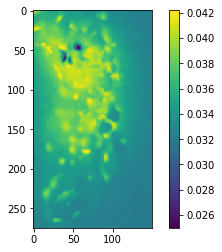

In [9]:
points, vals, img_conv = greedy_mp(img, weights, 300)

plt.imshow(np.max(img_conv, 2).T)
plt.colorbar()

In [10]:
recon_img = np.zeros((img.shape[0] + 2 * wx, img.shape[1] + 2 * wy, img.shape[2] + 2 * wz))
points_mod = points + np.array([wx, wy, wz])

for i in range(points_mod.shape[0]):
    
    pt = points_mod[i]
    x_sl = slice(pt[0] - wx, pt[0] + wx + 1)
    y_sl = slice(pt[1] - wy, pt[1] + wy + 1)
    z_sl = slice(pt[2] - wz, pt[2] + wz + 1)
    
    recon_img[x_sl, y_sl, z_sl] += vals[i] * weights
    
r_img = recon_img[wx:-wx, wy:-wy, wz:-wz]


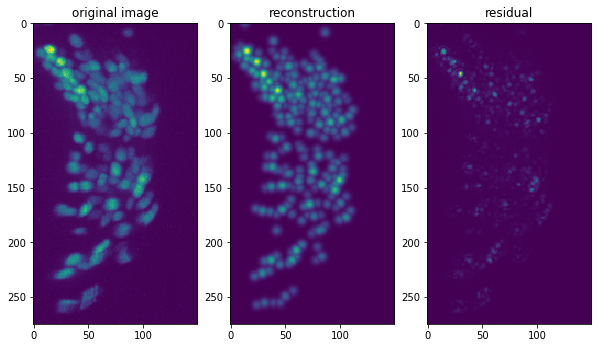

In [11]:
plt.figure(figsize=(10, 10))

plt.subplot(131)
plt.imshow(np.max(img, 2).T)
plt.title('original image')

plt.subplot(132)
plt.imshow(np.max(r_img, 2).T)
plt.title('reconstruction')

sq_res_img = (r_img - img) ** 2
plt.subplot(133)
plt.imshow(np.max(sq_res_img, 2).T)
plt.title('residual')

plt.savefig('greedy_mp_1.png')